# Fitness center customer analysis

A fitness center franchise called Model Fitness is developing a customer engagement strategy based on analytical data.
One of the most common problems encountered by fitness center services and even other services is customer turnover or customer churn.

- How do you know that a customer has stopped using your service?

You can indeed calculate the churn rate based on the number of people who delete accounts or don't renew their subscriptions. But sometimes, you can't know for sure if a client has actually quit: they may leave you without your knowledge.

The churn indicator can differ from field to field. If a user purchases from an online store not routinely but on a regular basis, you cannot say that the user has left your store. However, if for two weeks a user has not opened an online shop channel which is updated daily, then you can worry: your followers may have gotten bored and decided to leave you.

For fitness center businesses, a customer will be considered leaving if they do not return for one month. In fact, it is not necessarily true. A customer may not visit the fitness center for a month because he is on vacation, for example to Bali, and will return to visit the fitness center after the vacation is over. However, cases like this are rare. Usually, if a customer decides to join, then comes in a few times and then disappears, they are unlikely to come back.

To reduce churn rates, Model Fitness has digitized a number of its customer profiles. Your task is to analyze the profiles of these customers and develop a customer retention strategy (customer retention).
<!-- 
memprediksi pelanggan churn atau tidak (supervised machine learning-klasifikasi biner, algoritme regresi logistik atau decision tree, tidak terdapat struktur waktu, confusion matrix, accuracy, precision & recall, f1_score, roc_auc) -->

<b>Objective:</b>
- Analyzing customer profiles and developing customer retention strategies (customer retention).

<b>Stages:</b><a id='back'></a>

1. [Data Overview](#Start)
2. [Data Pre-processing](#Pre-processing)
3. [*Exploratory Data Analysis*](#EDA)
    - [Possible *outliers* in the features](#1)
    - [Correlation between features](#2)
4. [*Machine learning*](#ML)
    - [Binary classification model](#ML1)
    - [Create user cluster](#ML2)
    - [Recommendation](#ML3)
5. [General Conclusion](#Conclusion)

In [1]:
# Load all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset separators and scalers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Supervised Machine Learning Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Supervised Machine Learning metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

# Unsupervised Machine Learning Algorithm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# Unsupervised Machine Learning Metrics
from sklearn.metrics import silhouette_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Data Overview<a id='Start'></a>

In [2]:
# Load datasets
df = pd.read_csv('Y:\\Online Course\\Practicum\\Jupyter Notebook\\12 Project\\gym_churn_us.csv')

In [3]:
# Check general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
# Dataset size
df.shape

(4000, 14)

In [5]:
# Sample data
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [6]:
# Checking for duplicates
df.duplicated().sum()

0

In [7]:
# Checking for missing values
df.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Documentation:
- `Churn` — actual churn for the concerned month, `0` means still subscribed and `1` means unsubscribed

  User data for the previous month:
- `gender` - gender of customer, `0` means female and `1` means male
- `Near_Location` - whether the user lives or works near the gym location
- `Partner` - whether the user is an employee of a partner company (this gym has a partner company and their employees get a discount; in this case, the gym stores information about the company their customer works for)
- `Promo_friends` - whether the user initially signed up via the "refer a friend" offer (they used a friend's promo code when paying for their first membership)
- `Phone` - whether the user provides their phone number
- `Age` - the age of the customer
- `Lifetime` - time (in months) since the customer's first visit to the fitness center

  Data from visit and purchase logs and data regarding current membership status:
- `Contract_period` - 1 month, 3 months, 6 months or 1 year
- `Month_to_end_contract` - the remaining months before the contract expires
- `Group_visits` - whether the user is taking part in group sessions
- `Avg_class_frequency_total` - the average frequency of visits per week over the customer's lifetime
- `Avg_class_frequency_current_month` - average frequency of visits per week during the previous month
- `Avg_additional_charges_total` - the total amount of money spent to pay for other services in the gym: cafe, athletic goods, cosmetics, massage, etc.

**Tentative conclusion**

- Everything looks good, except that the column names can be changed to snake case.

[Back to stages](#back)

## Data Pre-processing<a id='Pre-processing'></a>

In [8]:
# Fixed column names
df.columns = df.columns.str.lower()

# Checking the result
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

[Back to stages](#back)

## *Exploratory Data Analysis*<a id='EDA'></a>

### Possible *outliers* in the features<a id='1'></a>

In [9]:
# General description of the dataset
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Possible outliers in the column:
`contract_period`, `age`, `avg_additional_charges_total`, `month_to_end_contract`, `lifetime`, `avg_class_frequency_total`, `avg_class_frequency_current_month`.

In [10]:
# Features average based on customer condition (churn or not)
df.groupby('churn').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Check features:
- `contract_period`,
- `age`,
- `avg_additional_charges_total`,
- `month_to_end_contract`,
- `lifetime`,
- `avg_class_frequency_total`,
- `avg_class_frequency_current_month`.

In [11]:
# Fungsi untuk menampilkan distribusi kolom
# Function to display fitures distribution
'''
Definition:
-----------
    # Function to display fitures distribution
-----------
    datasets:
        desired data
    h_col:
        hue parameter value in sns.histogram
    which_col:
        column of the desired parameter
    r_size:
        row sizes of subplots
    c_size:
        column sizes of the subplots
    f_size:
        the size of each subplot
'''
def show_dist (dataset, h_col, which_col, r_size, c_size, f_size):
    
    # Create subplots with size r_size x c_size
    fig, axs = plt.subplots(nrows=r_size, ncols=c_size, figsize=f_size)
    
    # Align the axs into a 1-dimensional array
    axs = axs.flatten()
    
    # Features
    cols_to_check = which_col
    
    # Loop for each feature and show its histogram
    for i, col in enumerate(cols_to_check):
        
        # Histograms
        sns.histplot(data=dataset, x=col, hue=h_col, kde=True, ax=axs[i], alpha=0.5, multiple='stack')
        
        # Histogram title
        axs[i].set_title(col)
        
        # x,y axis title
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')
    
    # Adjust spacing between subplots automatically
    plt.tight_layout()
    
    # Displays the result
    plt.show()

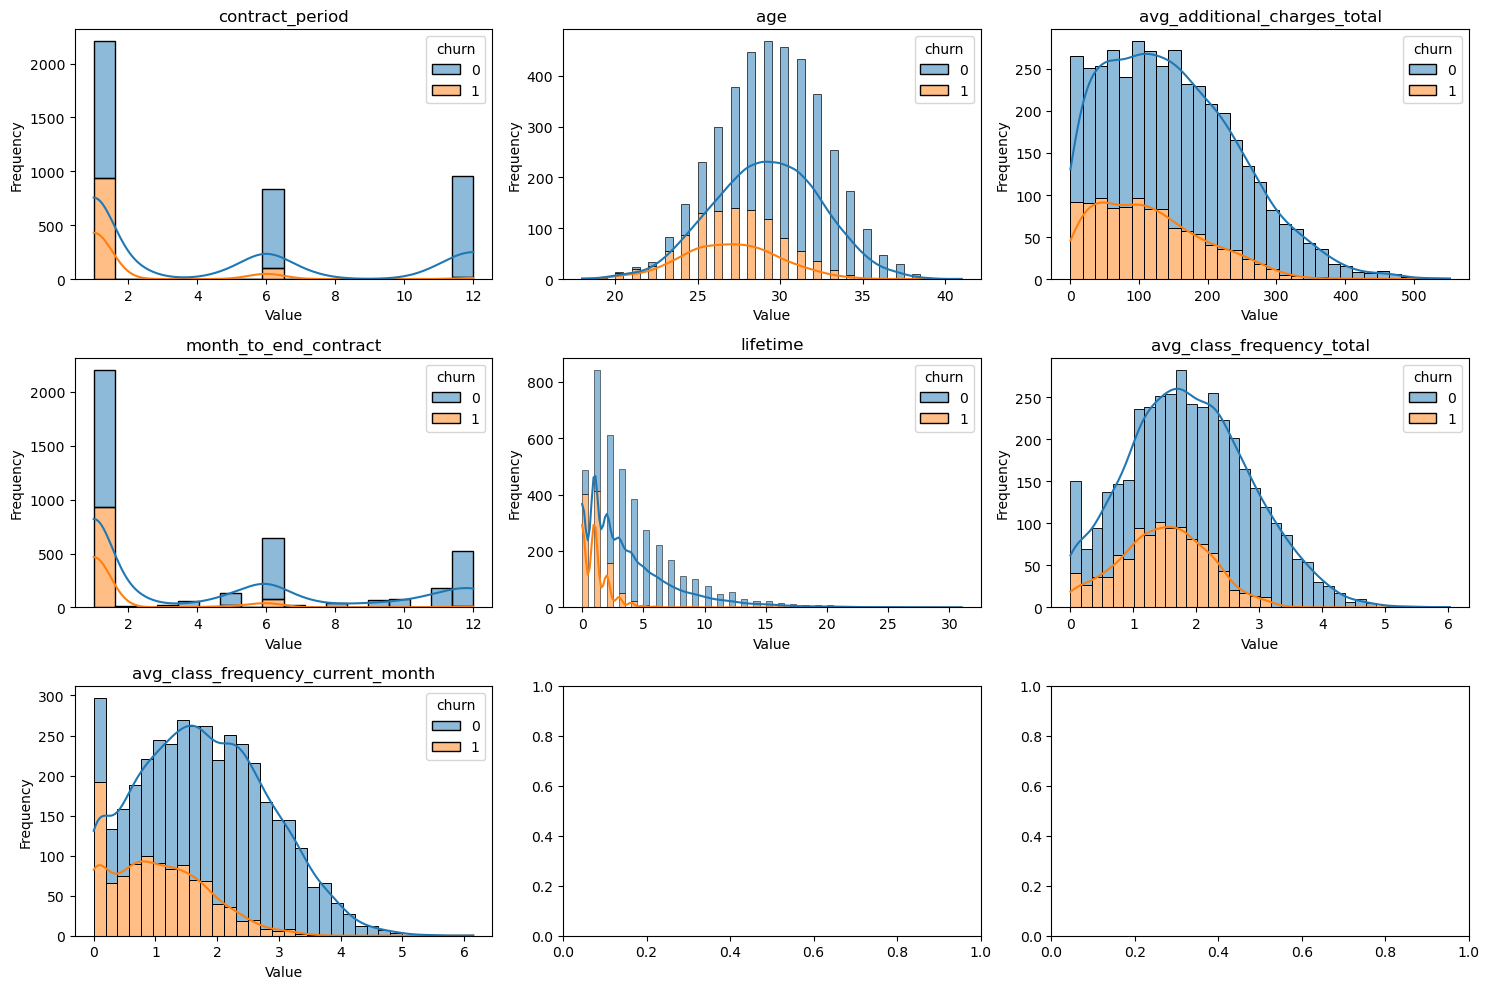

In [12]:
# Executes the function
show_dist(dataset = df,
          h_col = 'churn',
          which_col = ['contract_period', 'age', 'avg_additional_charges_total',
                       'month_to_end_contract', 'lifetime', 'avg_class_frequency_total',
                       'avg_class_frequency_current_month'],
          r_size = 3,
          c_size = 3,
          f_size = (15, 10))

It is proven that there is a skew or outliers in the features:

`contract_period`, `avg_additional_charges_total`, `month_to_end_contract`, `lifetime`, `avg_class _frequency_total`, and `avg_class_frequency_current_month`.

However, there is no evidence in the `age` column, where the data distribution looks normal.

In [13]:
# Function to remove outliers by column
'''
Definition:
-----------
    This function removes outliers based on columns that have outliers
-----------
    data:
        desired data
    column_name:
        column of the desired parameter
'''
def remove_outlier (data, column_name):
    
    df_filter = data
    
    for col in column_name:
        
        # Calculating Q1
        Q1 = data[col].quantile(0.25)
        # Menghitung Q3
        Q3 = data[col].quantile(0.75)
        
        # Calculates IQR
        IQR = Q3 - Q1
        
        # Calculating lower and upper wishkers
        minimum = Q1 - 1.5*IQR
        maximum = Q3 + 1.5*IQR
        
        # Filter lines based on upper wishkers and lower wishkers
        df_filter = df_filter.loc[(df_filter[col] >= minimum) & (df_filter[col] <= maximum)]
    return df_filter

In [14]:
# Outliers column
cols_outlier = ['contract_period', 'avg_additional_charges_total', 'month_to_end_contract',
                'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

# Remove the outliers with 'remove_outlier' function
df_new = remove_outlier (data=df, column_name=cols_outlier)

In [15]:
# The initial conditions of the dataset
df[cols_outlier].describe()

,contract_period,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,4.681250,146.943728,4.322750,3.724750,1.879020,1.767052
std,4.549706,96.355602,4.191297,3.749267,0.972245,1.052906
min,1.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,1.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,1.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,6.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,12.000000,552.590740,12.000000,31.000000,6.023668,6.146783


In [16]:
# The condition after removing the outliers in the dataset
df_new[cols_outlier].describe()

,contract_period,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000
mean,4.636122,143.839108,4.285790,3.141036,1.858491,1.739235
std,4.535006,92.644617,4.182172,2.690959,0.952885,1.036873
min,1.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,1.000000,67.543391,1.000000,1.000000,1.170861,0.937431
50%,1.000000,134.101921,1.000000,2.000000,1.819659,1.695335
75%,6.000000,207.724898,6.000000,5.000000,2.513596,2.481915
max,12.000000,416.707175,12.000000,11.000000,4.565136,4.779963


[Back to stages](#back)

### Correlation between features<a id='2'></a>

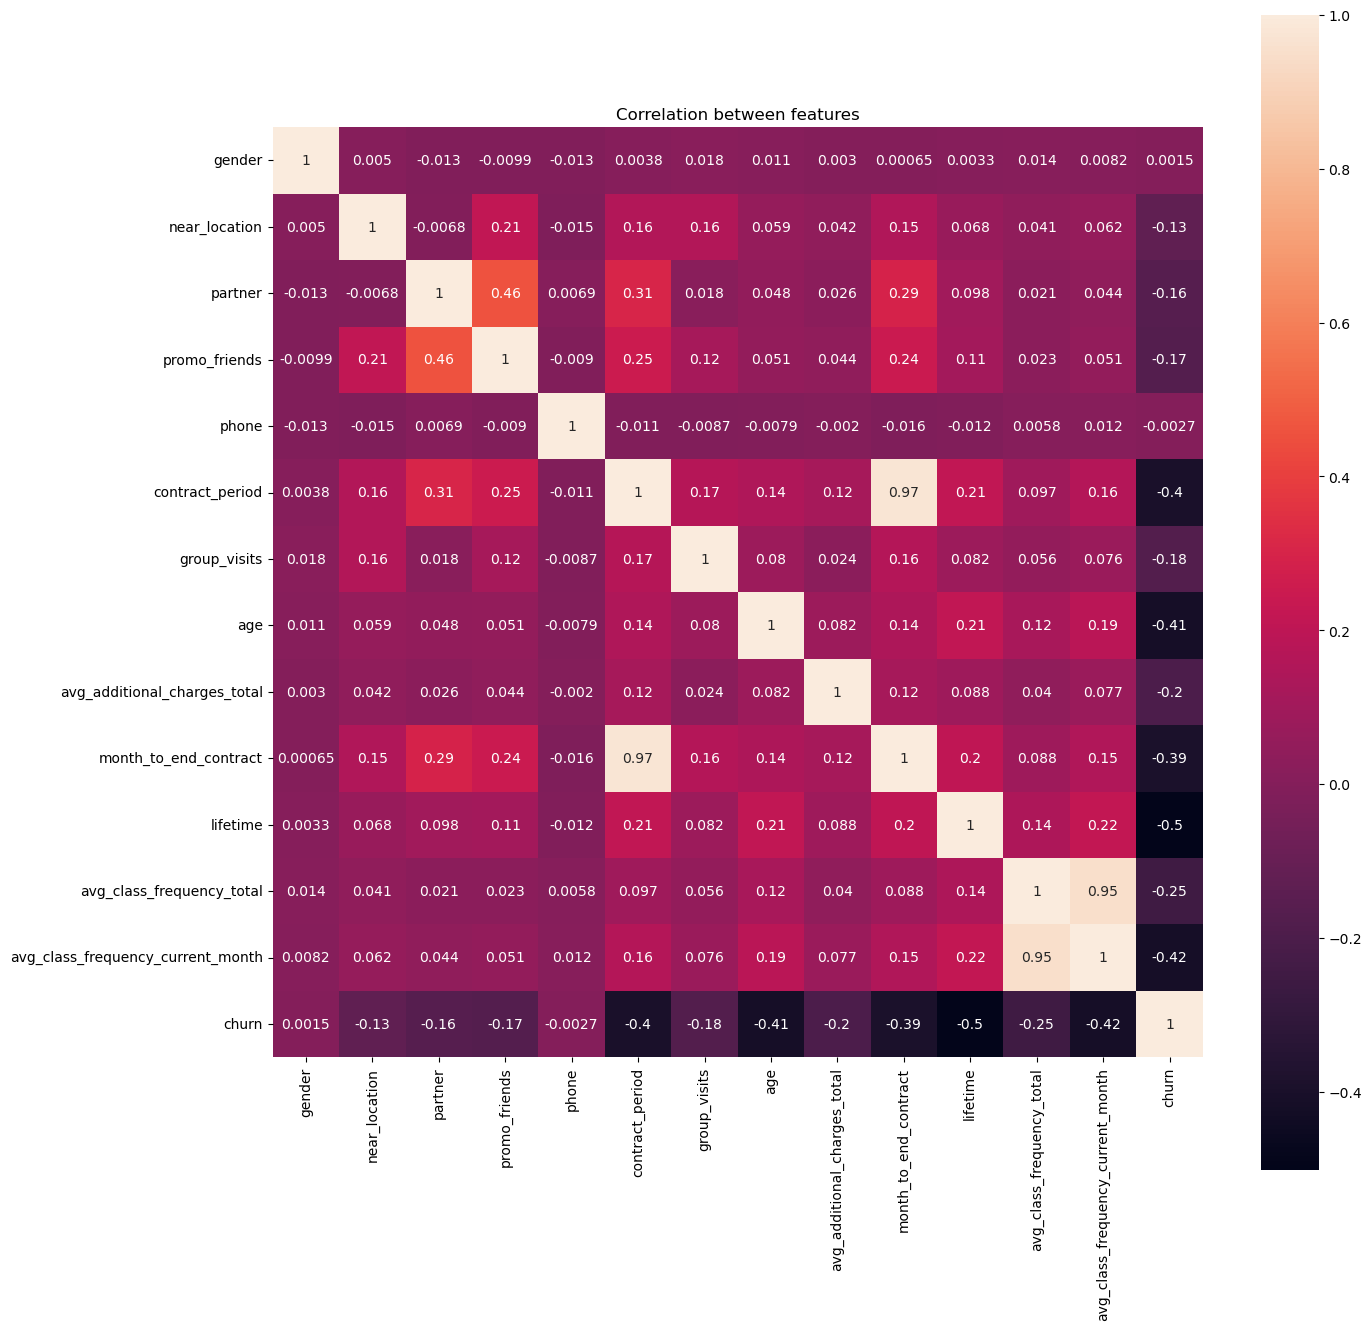

In [17]:
# Correlation matrix
corr_m = df_new.corr()

# Create heatmaps
plt.figure(figsize=(15, 15))

# Heatmap
sns.heatmap(corr_m, square=True, annot=True)

# Title
plt.title('Correlation between features')

# Displays the result
plt.show()

There is a strong correlation between `month_to_end_contract` with `contract_period`, then `avg_class_frequency_current_month` with `avg_class_frequency_total`.

and moderate correlation between `promo_friends` with `partner` features.

**Tentative conclusion**
1. There are outliers in several features, and improvements have been made to these features.
2. There is a strong and moderate correlation on the features that need to be considered before making machine learning models.

[Back to stages](#back)

## *Machine learning*<a id='ML'></a>

### Binary classification model<a id='ML1'></a>
Build a binary classification model to predict the churn probability (for the next month) for each customer.

The following 2 methods will be used:
   - logistic regression, and
   - random forest.

And compare the metrics of the two models:
   - accuracy,
   - precision, and
   - recall.

#### Divide and standardize data

In [18]:
# Reviewing the ratio between classes of datasets
print('Ratio between classes:\n', df_new['churn'].value_counts())

Ratio between classes:
 0    2705
1    1060
Name: churn, dtype: int64


In [19]:
# Dividing the data into features (X matrix) and target variables (y)
X = df_new.drop('churn', axis=1)
y = df_new['churn']

In [20]:
# Dividing the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
# Create a scaler class object
scaler = StandardScaler()

In [22]:
# Training standardizer
scaler.fit(X_train)

# Modify datasets
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [23]:
# Checking the mean and standard deviation for each feature before and after standardization

# Train data before standardization
X_train_before = pd.DataFrame(X_train, columns=X.columns)
print("Mean before standardization:\n", X_train_before.mean())
print("\nStandard deviasi before standardization:\n", X_train_before.std())

# Train data after standardization
X_train_after = pd.DataFrame(X_train_sc, columns=X.columns)
print("\nMean after standardization:\n", X_train_after.mean())
print("\nStandard deviasi after standardization:\n", X_train_after.std())

# Test data before standardization
X_test_before = pd.DataFrame(X_test, columns=X.columns)
print("Mean before standardization:\n", X_test_before.mean())
print("\nStandard deviasi before standardization:\n", X_test_before.std())

# Test data after standardization
X_test_after = pd.DataFrame(X_test_sc, columns=X.columns)
print("\nMean after standardization:\n", X_test_after.mean())
print("\nStandard deviasi after standardization:\n", X_test_after.std())

Mean before standardization:
 gender                                 0.510292
near_location                          0.852258
partner                                0.485060
promo_friends                          0.315737
phone                                  0.904714
contract_period                        4.637450
group_visits                           0.414675
age                                   29.168659
avg_additional_charges_total         144.143115
month_to_end_contract                  4.295817
lifetime                               3.164011
avg_class_frequency_total              1.868391
avg_class_frequency_current_month      1.748936
dtype: float64

Standard deviasi before standardization:
 gender                                0.499977
near_location                         0.354903
partner                               0.499860
promo_friends                         0.464886
phone                                 0.293658
contract_period                       4.544481
group_

Since it belongs to the binary classification, it can be solved or predicted using two algorithms: `Logistic Regression` and `RandomForestRegressor`.

#### Logistic regression

In [24]:
# Defines the model algorithm
lr_model = LogisticRegression()

# Train models
lr_model.fit(X_train_sc, y_train)

# Using trained models to make predictions
predictions_lr = lr_model.predict(X_test_sc)
probabilities_lr = lr_model.predict_proba(X_test_sc)[:,1]

In [25]:
# Displays metrics to evaluate the model
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions_lr)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions_lr)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions_lr)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions_lr)))

# Displays ROC-AUC score
print('ROC-AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities_lr)))

Accuracy: 0.91
Precision: 0.82
Recall: 0.86
F1: 0.84
ROC-AUC: 0.97


#### Random forest

In [26]:
# Defines the model algorithm
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)

# Train models
rf_model.fit(X_train_sc, y_train)

# Using trained models to make predictions
predictions_rf = rf_model.predict(X_test_sc)
probabilities_rf = rf_model.predict_proba(X_test_sc)[:,1]

In [27]:
# Displays metrics to evaluate the model
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions_rf)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions_rf)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions_rf)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions_rf)))

# Displays ROC-AUC score
print('ROC-AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities_rf)))

Accuracy: 0.90
Precision: 0.83
Recall: 0.81
F1: 0.82
ROC-AUC: 0.96


**Tentative conclusion**

1. In the logistic regression method, *accuracy* is 0.91, *precision* is 0.82, and *recall* is 0.86. Whereas in the *random forest* method, *accuracy* was 0.90, *precision* was 0.83, and *recall* was 0.81.

2. The result of the F1 score (harmonic average between precision and recall) for the logistic regression method is 0.84, greater than the *random forest* method, which is 0.82.

3. Based on the results of the ROC-AUC evaluation (*Area Under Curve* and *Receiver Operating Characteristic*), the two models, namely Logistic Regression and Random Forest, give quite good results, but the Logistic Regression model seems to give slightly better results (0.97) than the Random Forest model (0.96).

4. The ROC-AUC results indicate that the Logistic Regression model is better at classifying customers that will *churn*. So it can be concluded that the Logistic Regression model gives better results than the Random Forest model.

[Back to stages](#back)

### Create user cluster<a id='ML2'></a>

#### Agglomerative hierarchical clustering model

In [28]:
# Standardization of feature data
X_sc = scaler.fit_transform(X)

In [29]:
# Stores the table with a linked set of objects
linked = linkage(X_sc, method = 'ward')

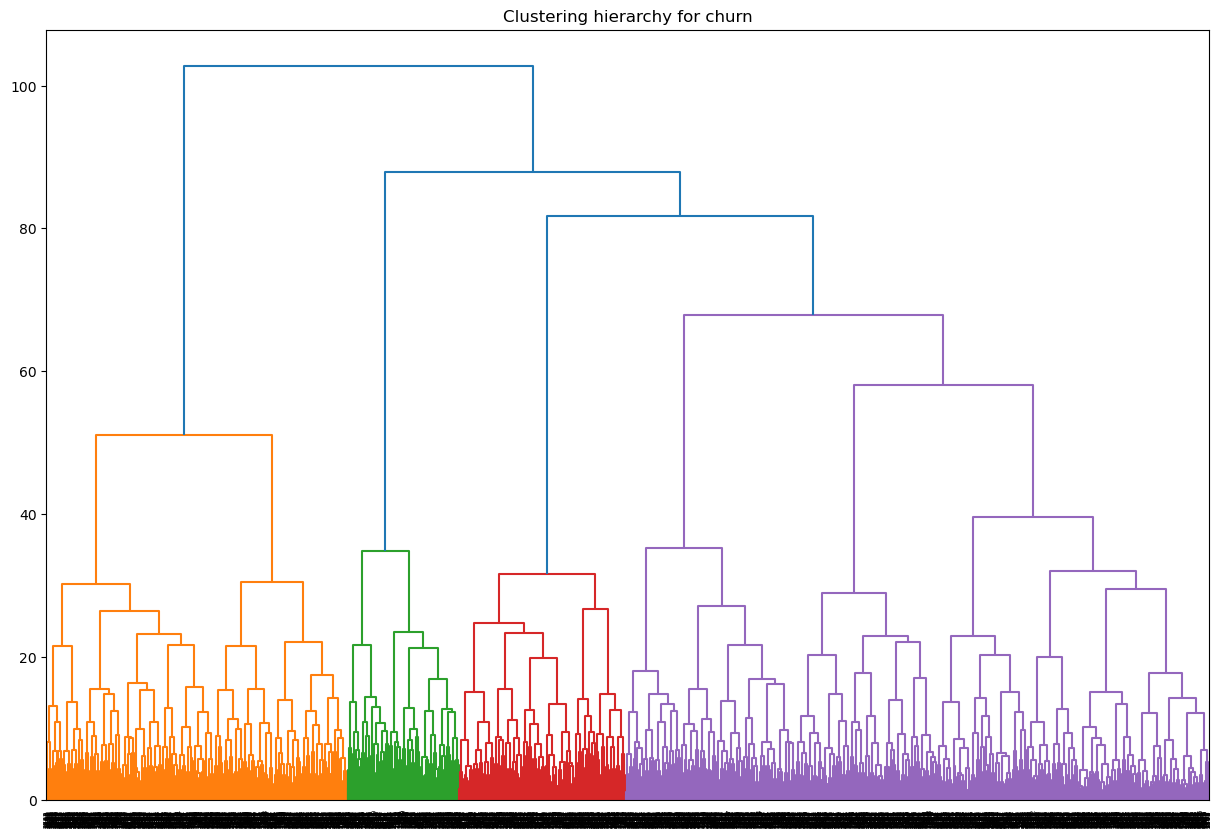

In [30]:
# Size
plt.figure(figsize=(15, 10))

#Dendograms
dendrogram(linked, orientation='top')

# Title
plt.title('Clustering hierarchy for churn')

# Displays the result
plt.show()

In [31]:
# Determine the model algorithm with the number of clusters = 4
km_model = KMeans(n_clusters=4)

# Train models
km_model.fit(X_sc)

# Perform customer cluster predictions
predicted_clusters = km_model.predict(X_sc)

In [32]:
# Shows silhouette scores for clustering
print('Skor silhouette: {:.2f}'.format(silhouette_score(X_sc, predicted_clusters)))

Skor silhouette: 0.13


The results were relatively low. However, it should be remembered that in the paired graphs, no groups can be clearly distinguished, so this is not surprising.

#### K-Means model

In [33]:
# Saves cluster labels to dataset fields
df_new['cluster_km'] = predicted_clusters

# Obtain statistical average feature value per cluster
df_new.groupby(['cluster_km']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.529086,0.858726,0.476454,0.321330,0.0,4.786704,0.421053,29.227147,144.396038,4.490305,3.238227,1.841555,1.701352,0.285319
1,0.500502,0.943831,0.779338,0.576730,1.0,10.718154,0.529589,29.888666,158.496481,9.790371,4.013039,1.983990,1.976778,0.029087
2,0.491861,0.757254,0.387827,0.194621,1.0,1.909413,0.295117,27.968153,127.650478,1.815287,1.905874,1.202614,0.936176,0.588110
3,0.535211,0.855131,0.339034,0.197183,1.0,2.357143,0.441650,30.052314,151.947843,2.202213,3.986922,2.671113,2.656305,0.097586


**Klaster 0:**

If we look at the average values of `contract_period`, `avg_additional_charges_total`, `lifetime` which are lower than the average of other clusters, it shows that customers in this cluster tend to:
    - have shorter contracts,
    - spending less money at the gym,
    - new and not very loyal customers.

According to some of these criteria, the `churn` value for this cluster is the highest, which indicates that customers with these criteria tend to stop subscribing.

**Klaster 1:**

If we look at the average values of `contract_period`, `avg_additional_charges_total`, `lifetime` which are higher than the average of other clusters, it shows that customers in this cluster tend to:
    - have a longer contract,
    - spending more money at the gym,
    - loyal customers and visiting the gym over a longer period of time.

In contrast to cluster 0, this cluster's `churn` value is the smallest, and this indicates that this criterion tends to be a regular customer.

**Klaster 2:**

1. The average value of `avg_class_frequency_total`, `avg_class_frequency_current_month` is higher than the average of other clusters, indicates that customers in this cluster tend to be more diligent in exercising at the gym.
2. The average value of `avg_additional_charges_total` is almost the same as the average for cluster 1, indicates that customers in this cluster also tend to spend the same amount of money like claster 1 at the gym.
3. The average `contract_period` value is not much different from cluster 0, indicates that customers in this cluster tend to have shorter contracts.
4. The average lifetime value is not much different from cluster 1, indicates that customers in this cluster tend to visit the gym for a longer period of time.

Cluster 2 has several things that differentiate it from other clusters:
   - Tend to have a high frequency of gym visits, but shorter contracts.
   - In terms of customer loyalty and spending money in gyms it is similar to cluster 1.

**Klaster 3:**

1. Customers in this cluster have a lower `churn` value than cluster 0, indicating that customers in this cluster are likely to unsubscribe from gyms, although the probability is not as high as cluster 0.
2. The average value of `avg_additional_charges_total`, `lifetime` is lower than the average for clusters 1 and 2, but higher than the average for cluster 0, spends less money at the gym, and has been a customer for some time but not yet fully loyal.
3. Customers in this cluster have a higher `contract_period` value than the average for clusters 0 and 2, indicates that customers in this cluster have moderate contracts.
4. The average values of `avg_class_frequency_total`, `avg_class_frequency_current_month` are lower than the average for clusters 2 and 1, indicates that customers in this cluster are still quite diligent in exercising at the gym, but perhaps not as active as customers in clusters 2 and 1.

Cluster 3 has several things that distinguish it from other clusters:
   - Tends to have been a loyal customer for some time, but not yet as loyal as customers in cluster 1.
   - Customers tend to spend less money at the gym than customers in clusters 1 and 2, but more than customers in cluster 0.
   - Subscribers have moderate contracts, which means they are more likely to consider the decision to subscribe in the medium term.

In [34]:
# Function to create a graph of paired features for clusters
'''
Definition:
-----------
    # Function to create a graph of paired features for clusters
-----------
    data:
        desired data
    x_name:
        column of the desired feature
    y_name:
        column of the desired feature
    cluster_name:
        column containing cluster data
'''
def show_clusters_on_plot(data, x_name, y_name, cluster_name):
    
    # Size
    plt.figure(figsize = (10, 10))
    
    # Scatterplots
    sns.scatterplot(x=data[x_name], y=data[y_name],
           hue = data[cluster_name], palette = 'Paired'
       )
    
    # Title
    plt.title('{} vs {}'.format(x_name, y_name))
    
    # Displays the result
    plt.show()

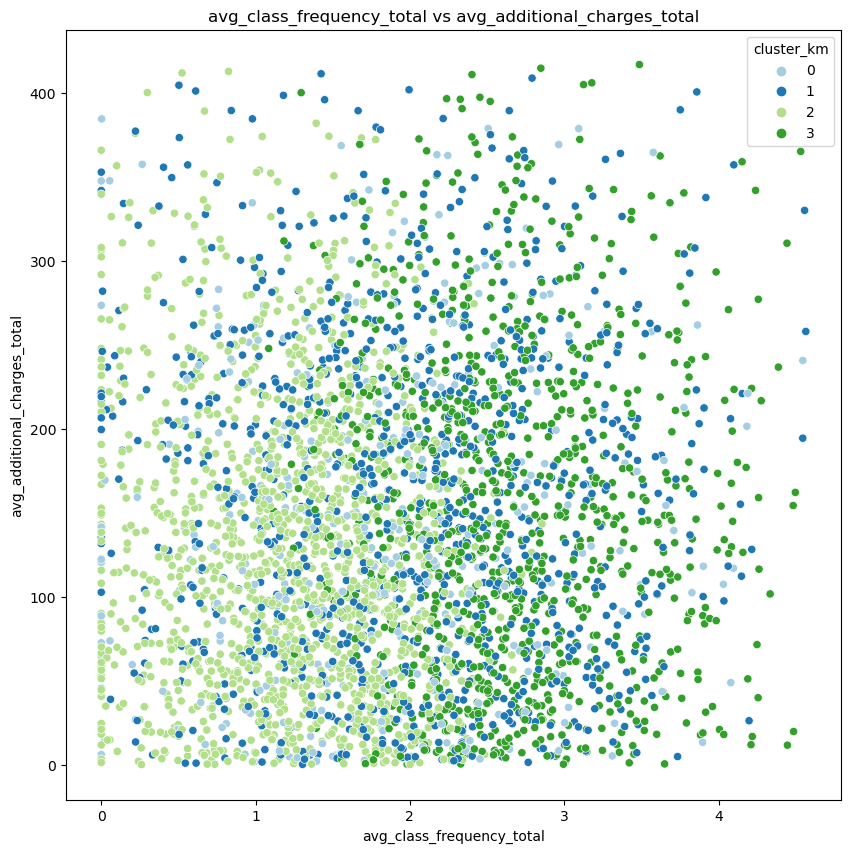

In [35]:
# Generating a graph for the feature pairs `avg_class_frequency_total` and `avg_additional_charges_total`
show_clusters_on_plot(df_new, 'avg_class_frequency_total', 'avg_additional_charges_total', 'cluster_km')

When viewed from the distribution based on the frequency of customer visits with the total amount of money spent,
- does not have a consistent trend in each cluster, and
- no cluster has a dominant tendency on one side of the graph.

This means that there is no clear pattern between the frequency of customer visits and the total amount of money spent, so that each customer may have different preferences in spending their money at the gym.

#### Distribution of features for each cluster

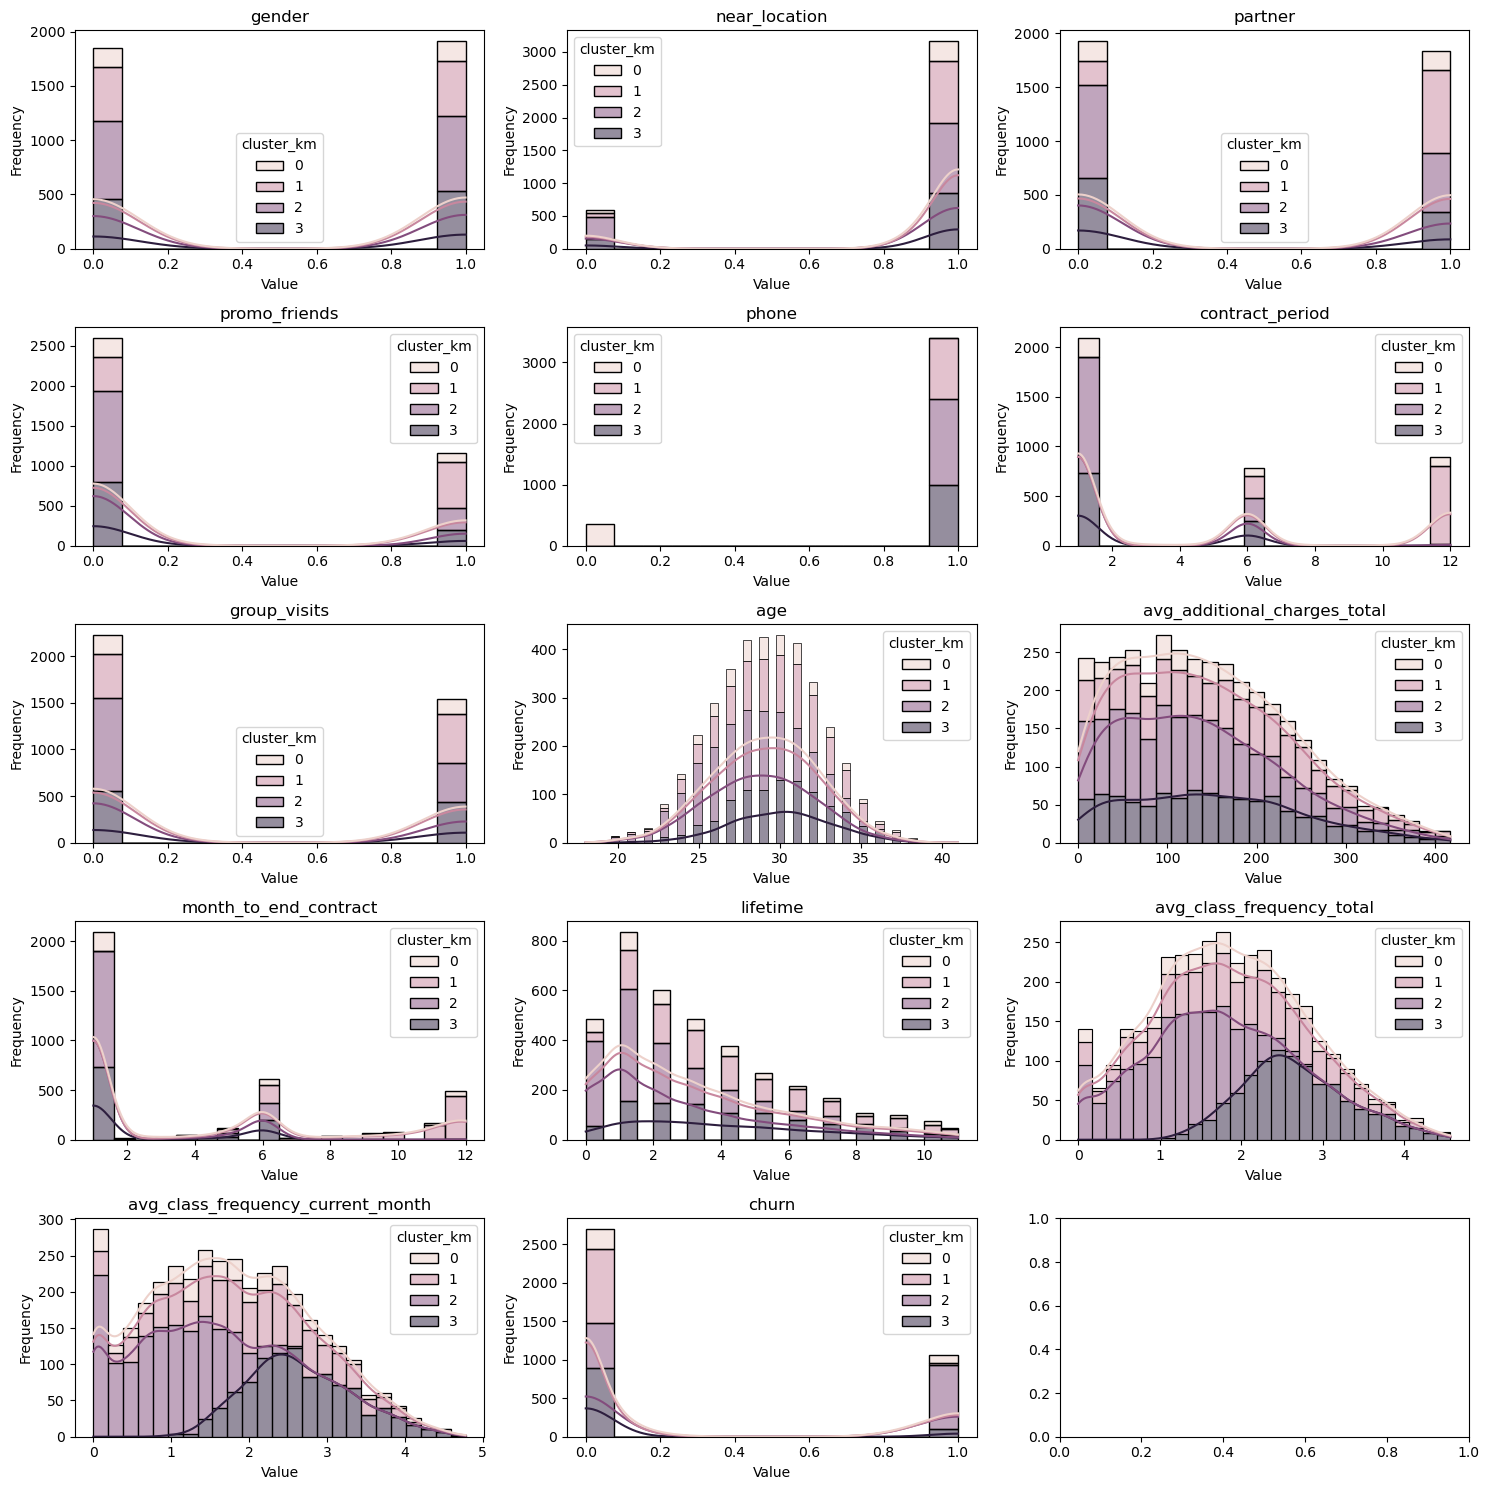

In [36]:
# Executes the function
show_dist(dataset = df_new,
          h_col = 'cluster_km',
          which_col = df_new.columns.drop('cluster_km'),
          r_size = 5,
          c_size = 3,
          f_size = (15, 15))

1. Based on the `lifetime` column, it can be seen that that in all clusters there is skewness to the right. This shows that the majority of gym customers have an active period that is less than the average, and there are a small number of customers who have a long active period.

2. Based on the `avg_class_frequency_current_month` column, it can be seen that that clusters 0 and 3 have skewness to the right, while clusters 1 and 2 have the same distribution. tend to be normal. This shows that the majority of customers in clusters 0 and 3 are less active in visiting the gym, while customers in clusters 1 and 2 are more active in attending gym classes.

3. Based on column `avg_additional_charges_total`, it can be seen that that all clusters also have skewness to the right. This shows that the majority of gym customers spend relatively small amounts of money, while there is a small number of customers who spend sizable amounts of money for other services in the gym: cafes, athletic goods, cosmetics, massages, etc.

#### churn rate for each cluster

In [37]:
# Calculate the churn rate and the number of subscribers in each cluster
df_churn_cluster = df_new.groupby('cluster_km').agg({
    'churn': 'mean',
    'gender': 'count'
}).sort_values(by='churn', ascending=False)

# Rename the column
df_churn_cluster = df_churn_cluster.rename(columns={'gender': 'count'})

# Displays the result
df_churn_cluster

,churn,count
cluster_km,,
2,0.588110,1413
0,0.285319,361
3,0.097586,994
1,0.029087,997


It can be seen that the rate of churn (the proportion of customers who leave) varies in each cluster. Cluster 0 has a very high churn rate of 59%, while cluster 1 has the lowest churn rate of only 3%.

The customer cluster that tends to leave is cluster 0, while those that tend to remain loyal are cluster 1. As for the other clusters, namely clusters 2 and 3, the churn rates vary quite a lot with a proportion of 10% and 26% respectively .

**Tentative conclusion**

It can be concluded that different customer clusters have different churn tendencies. Therefore, different marketing approaches can be carried out for each cluster in order to retain existing customers and reduce churn rates.

[Back to stages](#back)

### Recommendation<a id='ML3'></a>

Companies need to improve customer interaction and retention strategies to strengthen relationships with customers and increase their brand loyalty.

In this case, companies can apply several marketing principles that can help in increasing customer interaction and retention, such as:
1. Provide quality service: Companies can improve customer experience by providing friendly, fast, and responsive service. For example, companies can provide short response times to customer questions or complaints, and provide personalized customer service to provide a better customer experience.

2. Provide attractive incentives and promotions: Companies can provide attractive incentives and promotions to increase customer interest and loyalty. For example, a company can provide discounts or gifts for customers who shop frequently or provide referrals, this can be applied to clusters 0 and 3 which have a high *churn* rate.

3. Implement loyalty programs: Companies can develop attractive loyalty programs to increase customer retention. For example, companies can provide points or awards for every purchase made by customers, which can be exchanged for other products or prizes. This program can be applied to clusters 2 and 3 which have high loyalty.

By applying those principles, companies can strengthen relationships with customers and increase customer loyalty to brands, thereby increasing customer satisfaction and increasing the company's business growth.

[Back to stages](#back)

## General Conclusion<a id='Conclusion'></a>

After checking the dataset, fixed the column name:
1. Outliers on some features has been fixed,
2. After checking the correlation between features, there is a strong and moderate correlation that needs to be considered before creating a machine learning model,
3. Regression logistics and random forest are chosen to learn how to predict churn probability (for the next month) for each customer,
4. Then segment users by selecting the most dominant group, in this case cluster 0 being the most dominant, users in this cluster tend to have shorter contracts, spend less money at the gym, new customers and not too loyal,
5. Apply several marketing principles that can help in increasing customer interaction and retention, such as providing quality service, providing attractive incentives and promotions, and implementing a loyalty program.

[Back to stages](#back)